# Library Imports

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score,
                             precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler
from src.core.constants import NUM_COLS
import dill

## Data Accessing

In [2]:
df = pd.read_csv('data/preprocessed.csv')
print(df.shape)
df.head()

(29965, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,0,2,2,1,26,2,2,-1,-1,-2,...,366.6,250.6,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,4,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,2,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,2,1,2,1,53,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,19030.8,10000.0,9000.0,689.0,679.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29965 entries, 0 to 29964
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  29965 non-null  int64  
 1   SEX        29965 non-null  int64  
 2   EDUCATION  29965 non-null  int64  
 3   MARRIAGE   29965 non-null  int64  
 4   AGE        29965 non-null  int64  
 5   PAY_0      29965 non-null  int64  
 6   PAY_2      29965 non-null  int64  
 7   PAY_3      29965 non-null  int64  
 8   PAY_4      29965 non-null  int64  
 9   PAY_5      29965 non-null  int64  
 10  PAY_6      29965 non-null  int64  
 11  BILL_AMT1  29965 non-null  float64
 12  BILL_AMT2  29965 non-null  float64
 13  BILL_AMT3  29965 non-null  float64
 14  BILL_AMT4  29965 non-null  float64
 15  BILL_AMT5  29965 non-null  float64
 16  BILL_AMT6  29965 non-null  float64
 17  PAY_AMT1   29965 non-null  float64
 18  PAY_AMT2   29965 non-null  float64
 19  PAY_AMT3   29965 non-null  float64
 20  PAY_AM

## Dataset splitting

In [4]:
X = df.drop(columns=['target'])
y = df['target']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
X_train.shape, X_test.shape

((23972, 23), (5993, 23))

## Pipelines and Transformers

In [26]:
num_pipe = Pipeline([
    ('robust', RobustScaler()),
    ('std_scaler', StandardScaler()),
])

cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first')),
])

transformer = ColumnTransformer([
    ('num_pipe', num_pipe, NUM_COLS),
    ('cat_pipe', cat_pipe, ['SEX']),
])

## Cross Validation and Hyper-Parameter Tunning

In [21]:
def train_models(X, y, models):
    fitted_models = {}
    for name, config in models.items():
        model = config['model']
        params = config['params']
        scoring = ['accuracy_score', 'roc_auc_score', 'precision_score', 'recall_score', 'f1_score']
        gscv = GridSearchCV(model, params, cv=5, scoring=scoring, verbose=3)
        gscv.fit(X, y)
        fitted_models[name] = {
            'model': gscv,
            # 'accuracy_score': accuracy_score(X, y),
            # 'f1_score': f1_score(X, y),
            # 'roc_auc_score': roc_auc_score(X, y),
            # 'confusion_matrix': confusion_matrix(X, y)
        }
    return fitted_models

In [22]:
fitted_models = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100],
            'max_depth': [12],
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'penalty': ['l1', 'l2', 'elasticnet'],
            'fit_intercept': [True, False],
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            # 'kernel': ['linear', 'poly', 'rbf'],
            'C': [1, 10, 20],
        }
    },
}

## Data Transformation

## Model Training

In [27]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.fit_transform(X_test)

In [28]:
models_scores = train_models(X_train, y_train, fitted_models)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ....max_depth=12, n_estimators=100;, score=0.791 total time=   3.6s
[CV 2/5] END ....max_depth=12, n_estimators=100;, score=0.783 total time=   3.6s
[CV 3/5] END ....max_depth=12, n_estimators=100;, score=0.790 total time=   3.7s
[CV 4/5] END ....max_depth=12, n_estimators=100;, score=0.783 total time=   3.6s
[CV 5/5] END ....max_depth=12, n_estimators=100;, score=0.789 total time=   3.6s


## Model Prediction

In [29]:
rf = models_scores['Random Forest']['model']

In [30]:
y_pred = rf.predict(X_test)

## Model Evaluation

In [33]:
accuracy_score(y_test, y_pred)

0.7904221591857167

In [35]:
conf_matrix = confusion_matrix(y_test, y_pred)

<Axes: >

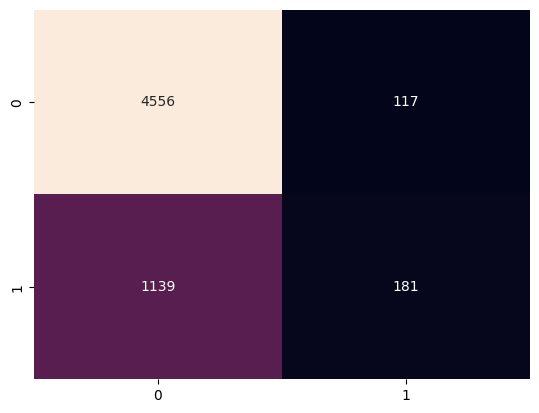

In [36]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)

<Axes: >

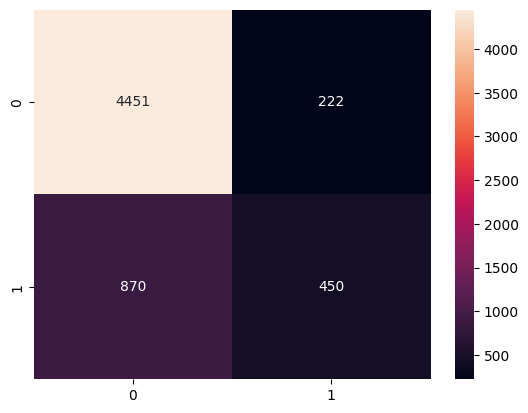

In [ ]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)

In [37]:
dill.dump(rf, open('model.dill', 'wb'))